In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.layers import Conv2D, Dense, Dropout, MaxPool2D, InputLayer, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
def pick_and_show_image(data, labels):
    i = np.random.randint(0, len(data), 1)[0]
    img = np.squeeze(data[i,:,:])
    y = labels[i]

    figsize=(3,3)
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap="gray")
    plt.title("Label : {}".format(y))
    plt.axis('off')
    plt.show()
    return img, y

## Read mnist data

In [4]:
(x_train_full, y_train_full), (x_test_full, y_test_full) = tf.keras.datasets.mnist.load_data()

In [5]:
print("training set shape: {}".format(x_train_full.shape))
print("training set label shape: {}".format(y_train_full.shape))
print("test set shape: {}".format(x_test_full.shape))
print("test set label shape: {}".format(y_test_full.shape))

training set shape: (60000, 28, 28)
training set label shape: (60000,)
test set shape: (10000, 28, 28)
test set label shape: (10000,)


#### Keep data from 5 to 9 included

In [6]:
# Find indices of labels 5 to 9
train_index = np.squeeze(np.argwhere(y_train_full>=5))
test_index = np.squeeze(np.argwhere(y_test_full>=5))

In [7]:
print(train_index.shape)
print(test_index.shape)

(29404,)
(4861,)


In [8]:
(x_train, y_train) = (x_train_full[train_index], y_train_full[train_index])
(x_test, y_test) = (x_test_full[test_index], y_test_full[test_index])

#### Preprocessing

- normalise image values
- binarise categorical labels

In [9]:
x_train_n = np.expand_dims(x_train/255, axis=-1).astype('float32')
x_test_n = np.expand_dims(x_test/255, axis=-1).astype('float32')

num_classes = 5

# convert class vectors to binary class matrices
y_train_b = to_categorical(y_train-5, num_classes)
y_test_b = to_categorical(y_test-5, num_classes)

In [10]:
print("training set shape [labels 5 to 9]: {}".format(x_train_n.shape))
print("training set label shape [labels 5 to 9]: {}".format(y_train_b.shape))
print("test set shape [labels 5 to 9]: {}".format(x_test_n.shape))
print("test set label shape [labels 5 to 9]: {}".format(y_test_b.shape))

training set shape [labels 5 to 9]: (29404, 28, 28, 1)
training set label shape [labels 5 to 9]: (29404, 5)
test set shape [labels 5 to 9]: (4861, 28, 28, 1)
test set label shape [labels 5 to 9]: (4861, 5)


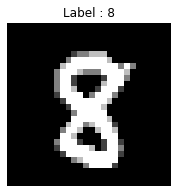

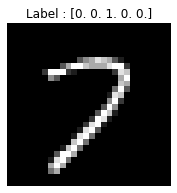

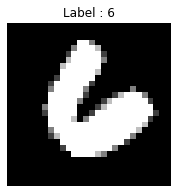

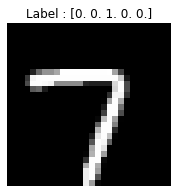

In [11]:
pick_and_show_image(x_train, y_train);
pick_and_show_image(x_train_n, y_train_b);
pick_and_show_image(x_test, y_test);
pick_and_show_image(x_test_n, y_test_b);

## Train classification model

In [12]:
model = tf.keras.Sequential(name="mnist529")
model.add(InputLayer((28, 28, 1), name="input"))
model.add(Conv2D(32, (3, 3), strides=(1, 1), padding="same", activation="relu", name="conv_1"))
model.add(MaxPool2D((2, 2), name="max_pool_1"))
model.add(Conv2D(64, (3, 3), strides=(1, 1), padding="same", activation="relu", name="conv_2"))
model.add(MaxPool2D((2, 2), name="max_pool_2"))
model.add(Dropout(.25, name="droput_025"))
model.add(Flatten(name="flatten"))
model.add(Dense(128, name="dense_1", activation="softmax"))
model.add(Dropout(.5, name="droput_05"))
model.add(Dense(5, name="dense_out", activation="softmax"))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [13]:
model.summary()

Model: "mnist529"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pool_2 (MaxPooling2D)    (None, 7, 7, 64)          0         
_________________________________________________________________
droput_025 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               401

In [22]:
optimizer = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [23]:
print('# Fit model on training data')
history = model.fit(x_train_n, y_train_b,
                    batch_size=32,
                    epochs=10,
                    validation_data=(x_test_n, y_test_b))

score = model.evaluate(x_test_n, y_test_b, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Fit model on training data
Train on 29404 samples, validate on 4861 samples
Epoch 1/10
29404/29404 [==============================] - 6s 205us/sample - loss: 1.6085 - acc: 0.2131 - val_loss: 1.6067 - val_acc: 0.2004
Epoch 2/10
29404/29404 [==============================] - 6s 197us/sample - loss: 1.4967 - acc: 0.2771 - val_loss: 1.1675 - val_acc: 0.4096
Epoch 3/10
29404/29404 [==============================] - 6s 196us/sample - loss: 1.2651 - acc: 0.3470 - val_loss: 0.8484 - val_acc: 0.6042
Epoch 4/10
29404/29404 [==============================] - 6s 197us/sample - loss: 1.1399 - acc: 0.4000 - val_loss: 0.7607 - val_acc: 0.6052
Epoch 5/10
29404/29404 [==============================] - 6s 197us/sample - loss: 1.0410 - acc: 0.4755 - val_loss: 0.5396 - val_acc: 0.7976
Epoch 6/10
29404/29404 [==============================] - 6s 197us/sample - loss: 0.9870 - acc: 0.4905 - val_loss: 0.4987 - val_acc: 0.7978
Epoch 7/10
29404/29404 [==============================] - 6s 197us/sample - loss: 

## Save model


In [24]:
if not "gan_evaluation" in os.listdir("./"):
    os.mkdir("gan_evaluation")
model.save("gan_evaluation/gan_evaluation_model.h5")

## Make prediction

In [14]:
saved_model = tf.keras.models.load_model("gan_evaluation/gan_evaluation_model.h5")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [12]:
y_pred = saved_model.predict_classes(x_test_n)+5

In [14]:
y_pred[0]

7

In [15]:
y_prob = saved_model.predict(x_test_n)

In [21]:
print(y_prob[0,:])
print(np.max(y_prob[0,:]))
print(np.argmax(y_prob[0,:])+5)

[0.00891332 0.00735935 0.8693758  0.01363309 0.10071845]
0.8693758
7


In [27]:
np.argwhere((y_pred - y_test)==0).shape[0]/len(y_test)

0.988274017691833

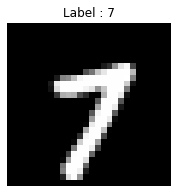

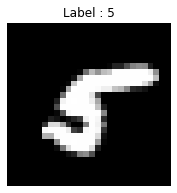

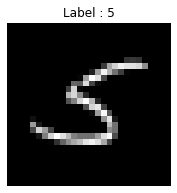

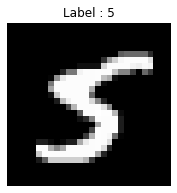

In [28]:
pick_and_show_image(x_test_n, y_pred);
pick_and_show_image(x_test_n, y_pred);
pick_and_show_image(x_test_n, y_pred);
pick_and_show_image(x_test_n, y_pred);

In [15]:
import matplotlib.pyplot as plt

In [16]:
batch_size = 32
generated_images = x_test_n[:batch_size, :, :, :]
# predictions
y_prob = saved_model.predict(generated_images)
for i in range(batch_size):
    label = np.argmax(y_prob[i,:])+5
    prob = np.max(y_prob[i,:])
    # PLOT
    plt.subplot(4, 8, 1 + i)
    plt.axis('off')
    plt.imshow(generated_images[i, :, :, 0], cmap='gray_r')
    plt.title("L={}\nP={:.2f}".format(label, prob), size=10)
plt.savefig(os.path.join("gan_evaluation", "test"), dpi=100)
plt.close()
    
        